# Data Cleaning Process

Drop missing values

In [ ]:
#Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import zero_one_loss, roc_curve, roc_auc_score


In [ ]:
from google.colab import drive

file_path = '/content/sample_data/adult.data.csv'

df = pd.read_csv(file_path)
df.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'country', 'income']
df.shape

(32560, 15)

In [ ]:
# Preprocess: process missing value and query wanted data
df_filtered = df.copy()

for col in df.columns:
    df_filtered = df_filtered[df_filtered[col] != ' ?']

df_filtered.reset_index(drop=True, inplace=True)
df_filtered

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30156,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
30157,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
30158,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
30159,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


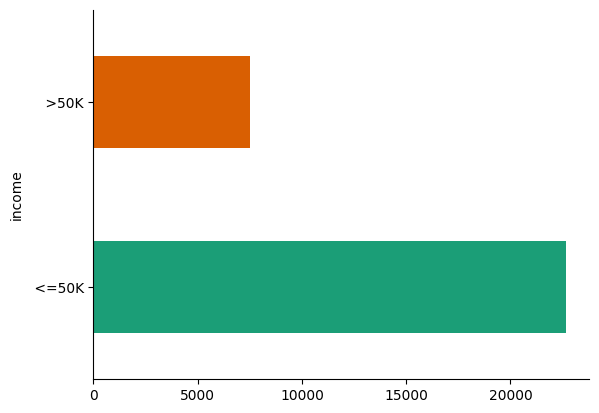

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
df_filtered.groupby('income').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

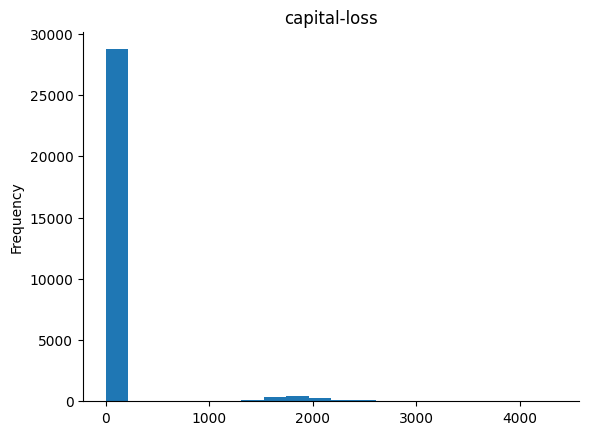

In [ ]:
df_filtered['capital-loss'].plot(kind='hist', bins=20, title='capital-loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Explain: Capital Loss represents the loss an individual incurs when they sell an asset for less than its original purchase price.
# From the distribution of capital-loss in the dataset, we observe that the majority of data has value of 0 which can be insiginificant in the training process and might also produce noise.

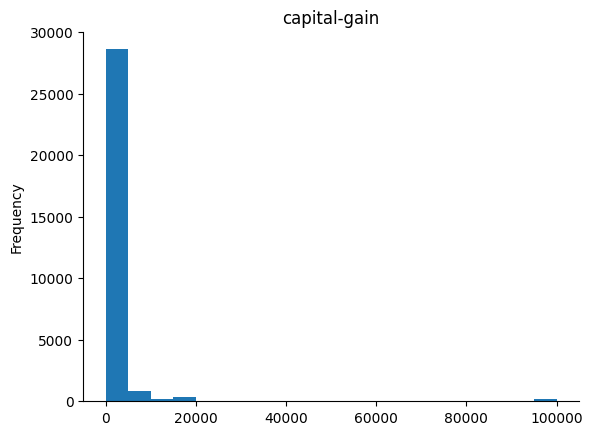

In [ ]:
df_filtered['capital-gain'].plot(kind='hist', bins=20, title='capital-gain')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Explain: Capital Gain represents the profit made from selling an asset (like stocks, bonds, or real estate) for more than its original purchase price.

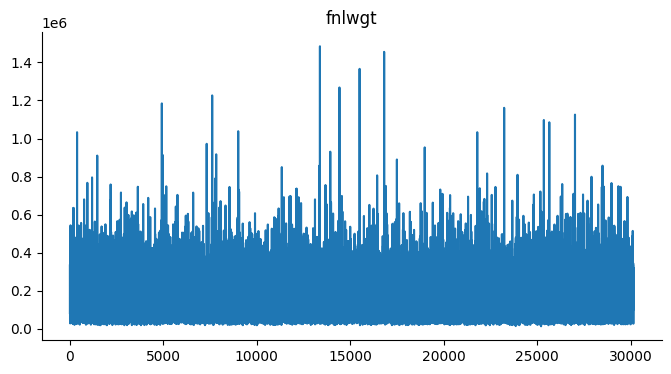

In [ ]:
from matplotlib import pyplot as plt
df_filtered['fnlwgt'].plot(kind='line', figsize=(8, 4), title='fnlwgt')
plt.gca().spines[['top', 'right']].set_visible(False)

# From this plot, we observe that this feature has a wide range and might have significant affect on models like KNN, so we decide to standardize this feature.

In [ ]:
df_us = df_filtered[df_filtered['country'] == ' United-States']
df_us = df_us.drop('country', axis=1)
df_us = df_us.drop('fnlwgt', axis=1)
df_us.shape

(27503, 13)

# Model Training

Want to explore relationship between individual features with target and combination of features

Want to compare how the relationship is different among features

Want to identify the weights (effect) of each feature on prediction


In [ ]:
# Split data

# Split into X,Y
# Base dataset where all features are included
X = df_us.drop('income', axis=1)
y = df_us['income']


# Standardize data for equal weight
numerical_cols = ['age', 'education-num', 'hours-per-week', 'capital-loss', 'capital-gain']
scaler = StandardScaler()
for feature in numerical_cols:
    X[feature] = scaler.fit_transform(X[[feature]])
    print(f"{feature}: {scaler.mean_}")

# Encode categorical label into numerical values
categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex']
y = [0 if (val == ' <=50K') else 1 for val in y]
encoder = LabelEncoder()
for feature in categorical_cols:
    X[feature] = encoder.fit_transform(X[feature])
    category_to_number = dict(zip(encoder.classes_, range(len(encoder.classes_))))
    print(f"{feature}: {category_to_number}")


# Split data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)


age: [38.50427226]
education-num: [10.2220485]
hours-per-week: [40.97102134]
capital-loss: [90.27600625]
capital-gain: [1120.46147693]
workclass: {' Federal-gov': 0, ' Local-gov': 1, ' Private': 2, ' Self-emp-inc': 3, ' Self-emp-not-inc': 4, ' State-gov': 5, ' Without-pay': 6}
education: {' 10th': 0, ' 11th': 1, ' 12th': 2, ' 1st-4th': 3, ' 5th-6th': 4, ' 7th-8th': 5, ' 9th': 6, ' Assoc-acdm': 7, ' Assoc-voc': 8, ' Bachelors': 9, ' Doctorate': 10, ' HS-grad': 11, ' Masters': 12, ' Preschool': 13, ' Prof-school': 14, ' Some-college': 15}
marital-status: {' Divorced': 0, ' Married-AF-spouse': 1, ' Married-civ-spouse': 2, ' Married-spouse-absent': 3, ' Never-married': 4, ' Separated': 5, ' Widowed': 6}
occupation: {' Adm-clerical': 0, ' Armed-Forces': 1, ' Craft-repair': 2, ' Exec-managerial': 3, ' Farming-fishing': 4, ' Handlers-cleaners': 5, ' Machine-op-inspct': 6, ' Other-service': 7, ' Priv-house-serv': 8, ' Prof-specialty': 9, ' Protective-serv': 10, ' Sales': 11, ' Tech-support': 1

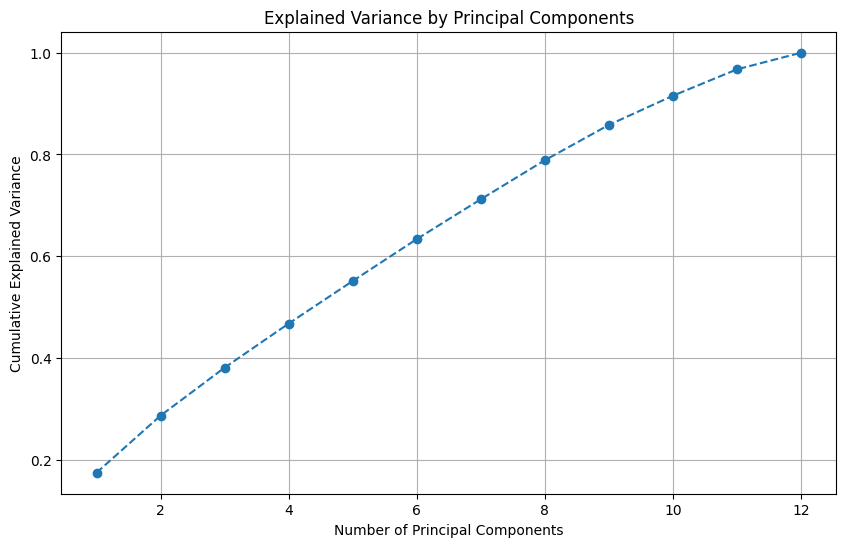

In [ ]:
from sklearn.decomposition import PCA

X_train_copy = X_train.copy()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_copy)
pca = PCA(n_components=X_train_scaled.shape[1])  # We keep all components
pca.fit(X_train_scaled)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

# Plot the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# Step 4: Display the components and their contribution to the variance
# Check the loadings of the first few principal components
components = pca.components_

In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

X_copy2 = X_train_copy.copy()
y_copy = y_train.copy()  # Target

# Encode categorical variables using LabelEncoder for simplicity (you may want to use OneHotEncoding for more complex datasets)
le = LabelEncoder()
X_copy2 = X_copy2.apply(le.fit_transform)  # Encode categorical columns

# Standardize the features (important for algorithms like KNN, Logistic Regression)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_copy2)

# Apply SelectKBest with Chi-Squared test (you can choose another score function based on your needs)
selector = SelectKBest(score_func=mutual_info_classif, k='all')  # 'all' will return all features' scores
X_new = selector.fit_transform(X_scaled, y_copy)

# Get the scores for each feature
feature_scores = pd.DataFrame(selector.scores_, index=X_copy2.columns, columns=["Score"])

# Rank features based on their score
feature_scores = feature_scores.sort_values(by="Score", ascending=False)

# Display the ranked features in the desired format
print("Ranked attributes:")
for i, (index, row) in enumerate(feature_scores.iterrows()):
    print(f"{round(row['Score'], 3)} {i+1} {index}")

Ranked attributes:
0.114 1 relationship
0.111 2 marital-status
0.085 3 capital-gain
0.066 4 education-num
0.064 5 age
0.062 6 occupation
0.06 7 education
0.044 8 hours-per-week
0.033 9 sex
0.031 10 capital-loss
0.01 11 workclass
0.009 12 race


Loadings for the first principal component:
age              -0.320971
workclass        -0.130352
education        -0.093467
education-num    -0.209523
marital-status    0.321910
occupation       -0.061037
relationship      0.533161
race             -0.188862
sex              -0.465189
capital-gain     -0.149333
capital-loss     -0.113135
hours-per-week   -0.385446
Name: 0, dtype: float64


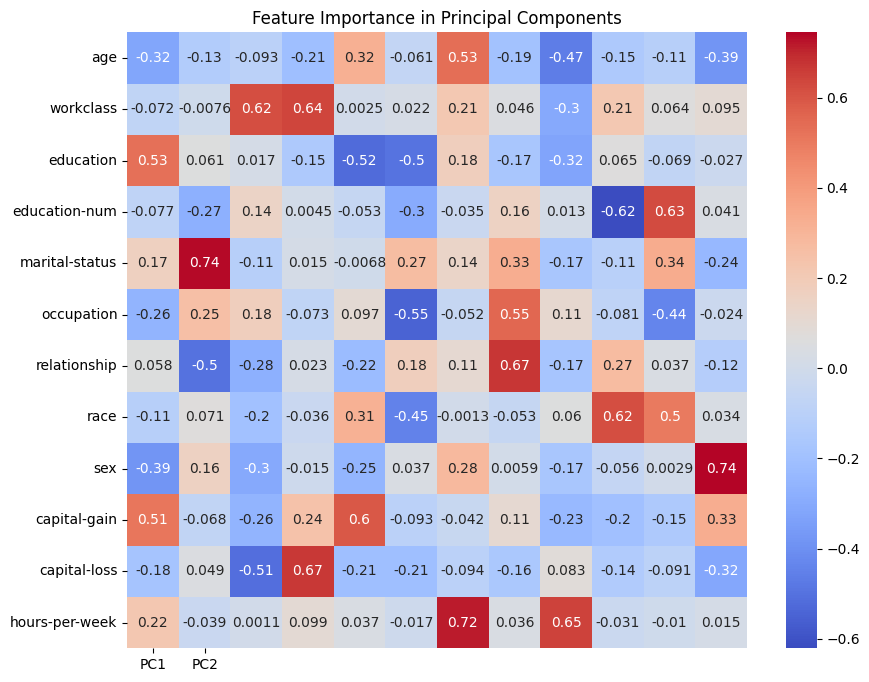

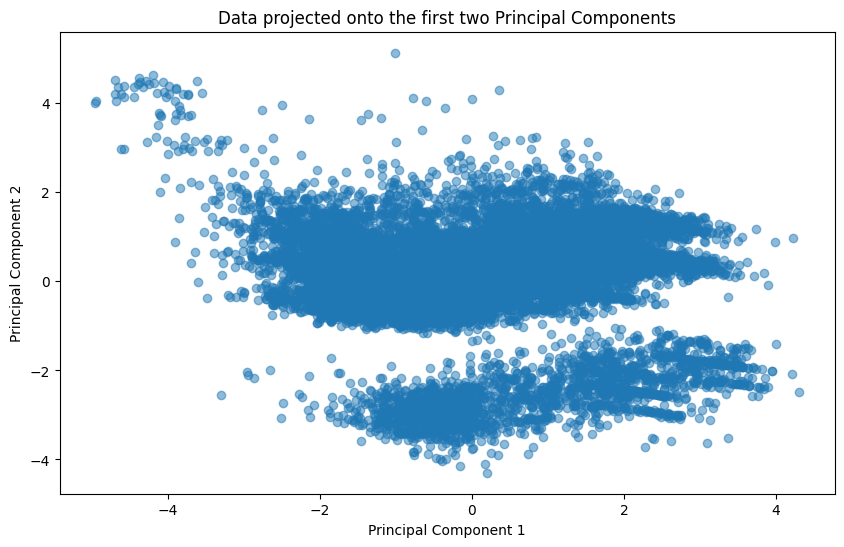

In [ ]:
pca_loadings = pd.DataFrame(components, columns=X_train.columns)
import seaborn as sns
# Display the loadings of the first principal component (the most significant one)
print("Loadings for the first principal component:")
print(pca_loadings.iloc[0])  # The first row contains the loadings of the first principal component

plt.figure(figsize=(10, 8))
sns.heatmap(pca_loadings, annot=True, cmap='coolwarm', xticklabels=['PC1', 'PC2'], yticklabels=X_train.columns)
plt.title('Feature Importance in Principal Components')
plt.show()

# Step 5: Visualize the data projected onto the first two principal components
X_train_pca = pca.transform(X_train_scaled)  # Project data onto the principal components

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Data projected onto the first two Principal Components')
plt.show()

# Binary Logistic Regression

In [ ]:

def log_regression(X_train, X_test, y_train, y_test):
    log_reg = LogisticRegression()
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
        'penalty': ['l2'],  # Regularization type
        'max_iter': [100, 200, 300]  # Max iterations for convergence
    }
    grid_search = GridSearchCV(log_reg, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_log_reg = grid_search.best_estimator_
    best_log_reg.fit(X_train, y_train)
    y_pred = best_log_reg.predict(X_test)

    training_error = zero_one_loss(y_train, best_log_reg.predict(X_train))
    testing_error = zero_one_loss(y_test, y_pred)

    y_scores_log = best_log_reg.predict_proba(X_test)[:, 1]

    return (np.round(training_error,3), np.round(testing_error,3), y_scores_log)

def SGDC_regression(X_train, X_test, y_train, y_test):
    sgd_reg = SGDClassifier(loss='log_loss', warm_start=True, learning_rate='adaptive', eta0 = 1e-3)
    param_grid = {
        'alpha': [0.0001, 0.001, 0.01, 0.1],  # Regularization strength (L2 penalty)
        'max_iter': [100, 200, 300],  # Max iterations for convergence
    }
    grid_search = GridSearchCV(sgd_reg, param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_sgd_reg = grid_search.best_estimator_
    best_sgd_reg.fit(X_train, y_train)
    y_pred = best_sgd_reg.predict(X_test)
    training_error = zero_one_loss(y_train, best_sgd_reg.predict(X_train))
    testing_error = zero_one_loss(y_test, y_pred)

    y_scores_sgd = best_sgd_reg.predict_proba(X_test)[:, 1]

    return (np.round(training_error,3), np.round(testing_error,3), y_scores_sgd)



# Random Forest Classifier

In [ ]:
def random_forest_classifer(X_tr, X_te, y_tr, y_te):
    #Model and fit training data
    rf = RandomForestClassifier(n_estimators = 250, max_depth = 12, min_samples_split = 10, min_samples_leaf = 3, max_features = 'log2', bootstrap = True, random_state = 1234)
    rf.fit(X_tr, y_tr)

    #Get training error
    y_tr_pred = rf.predict(X_tr)
    training_error = zero_one_loss(y_tr, y_tr_pred)

    #Get testing error
    y_te_pred = rf.predict(X_te)
    testing_error = zero_one_loss(y_te, y_te_pred)

    y_scores_rf  = rf.predict_proba(X_test)[:, 1]

    #Return a tuple of (training error, testing error)
    return (np.round(training_error,3), np.round(testing_error,3), y_scores_rf)

# KNN Classifier

In [ ]:
def knn_classifier(X_tr, X_te, y_tr, y_te):
    knn = KNeighborsClassifier(n_neighbors=12)  # Choose n_neighbor = 14 since test error is the lowest
    knn.fit(X_tr, y_tr)
    y_scores_knn = knn.predict_proba(X_test)[:, 1]
    return np.round(zero_one_loss(y_tr, knn.predict(X_tr)), 3), np.round(zero_one_loss(y_te, knn.predict(X_te)), 3), y_scores_knn

# Gradient Boosting

In [ ]:
# NOTE: y_tr and y_te must be [0,1]
def xgboost(X_tr, X_te, y_tr, y_te):
    xgb = XGBClassifier(n_estimators=200, max_depth=3, learning_rate=0.1, random_state=1234)
    xgb.fit(X_tr, y_tr)
    y_scores_xgb = xgb.predict_proba(X_test)[:, 1]
    return np.round(zero_one_loss(y_tr, xgb.predict(X_tr)), 3), np.round(zero_one_loss(y_te, xgb.predict(X_te)), 3), y_scores_xgb

# Significance Feature Test

Want to test signficance of each feature by dropping individual feature and compare with base dataset where all features are included

In [ ]:
rf_error = random_forest_classifer(X_train, X_test, y_train, y_test)

In [ ]:
log_error = log_regression(X_train, X_test, y_train, y_test)

In [ ]:
sgd_error = SGDC_regression(X_train, X_test, y_train, y_test)

In [ ]:
knn_error = knn_classifier(X_train, X_test, y_train, y_test)

In [ ]:
xgb_error = xgboost(X_train, X_test, y_train, y_test)

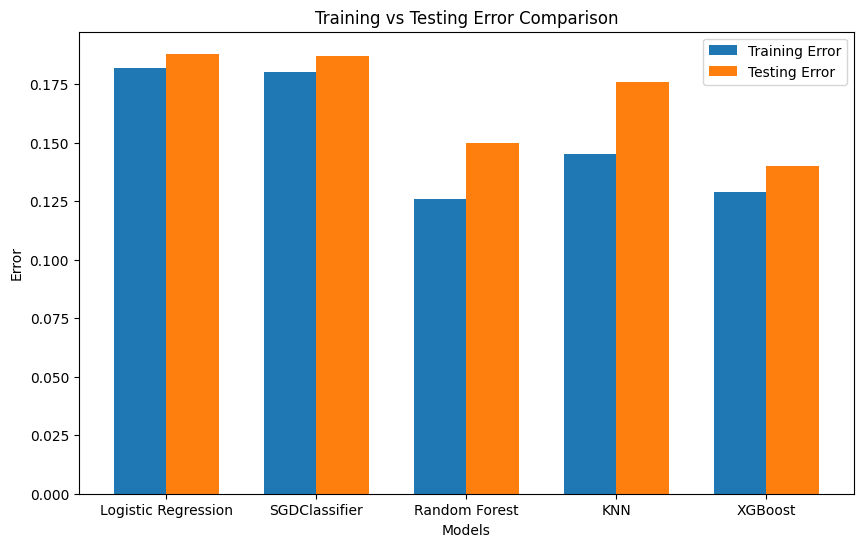

In [ ]:
model_names = ['Logistic Regression', 'SGDClassifier', 'Random Forest', 'KNN', 'XGBoost']
training_errors = [log_error[0], sgd_error[0], rf_error[0], knn_error[0], xgb_error[0]]
testing_errors = [log_error[1], sgd_error[1], rf_error[1], knn_error[1], xgb_error[1]]

plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(model_names))

plt.bar(index, training_errors, bar_width, label='Training Error')
plt.bar(index + bar_width, testing_errors, bar_width, label='Testing Error')

plt.xlabel('Models')
plt.ylabel('Error')
plt.title('Training vs Testing Error Comparison')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()

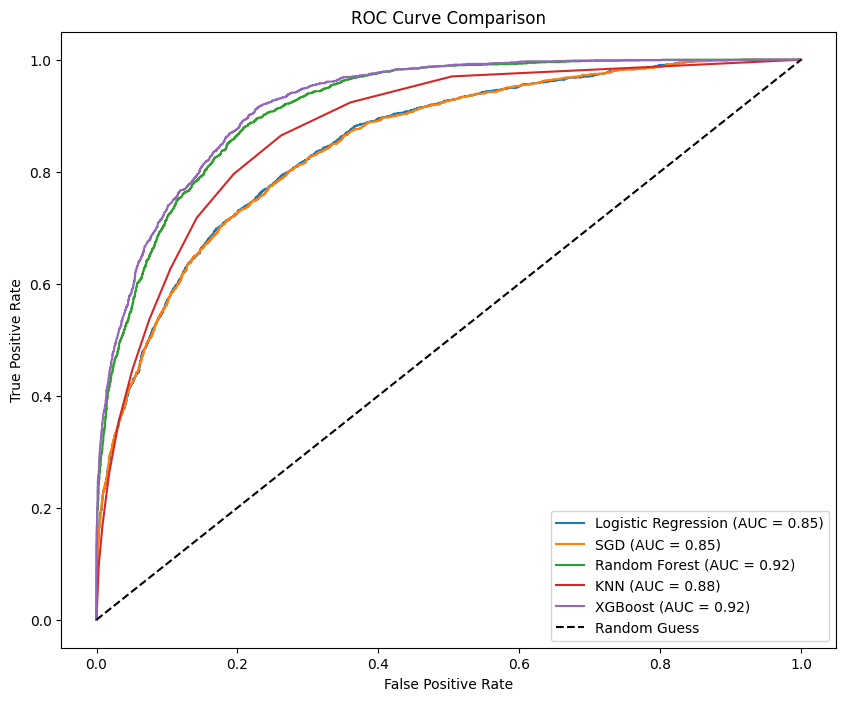

In [ ]:
y_scores_log = log_error[2]
y_scores_sgd = sgd_error[2]
y_scores_rf  = rf_error[2]
y_scores_knn = knn_error[2]
y_scores_xgb = xgb_error[2]

# Compute ROC curves for each model
fpr_log, tpr_log, _ = roc_curve(y_test, y_scores_log)
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, y_scores_sgd)
fpr_rf,  tpr_rf,  _ = roc_curve(y_test, y_scores_rf)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_scores_knn)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_scores_xgb)

# Compute AUC scores for each model
auc_log = roc_auc_score(y_test, y_scores_log)
auc_sgd = roc_auc_score(y_test, y_scores_sgd)
auc_rf  = roc_auc_score(y_test, y_scores_rf)
auc_knn = roc_auc_score(y_test, y_scores_knn)
auc_xgb = roc_auc_score(y_test, y_scores_xgb)

# Plotting the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {auc_log:.2f})')
plt.plot(fpr_sgd, tpr_sgd, label=f'SGD (AUC = {auc_sgd:.2f})')
plt.plot(fpr_rf, tpr_rf,   label=f'Random Forest (AUC = {auc_rf:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()

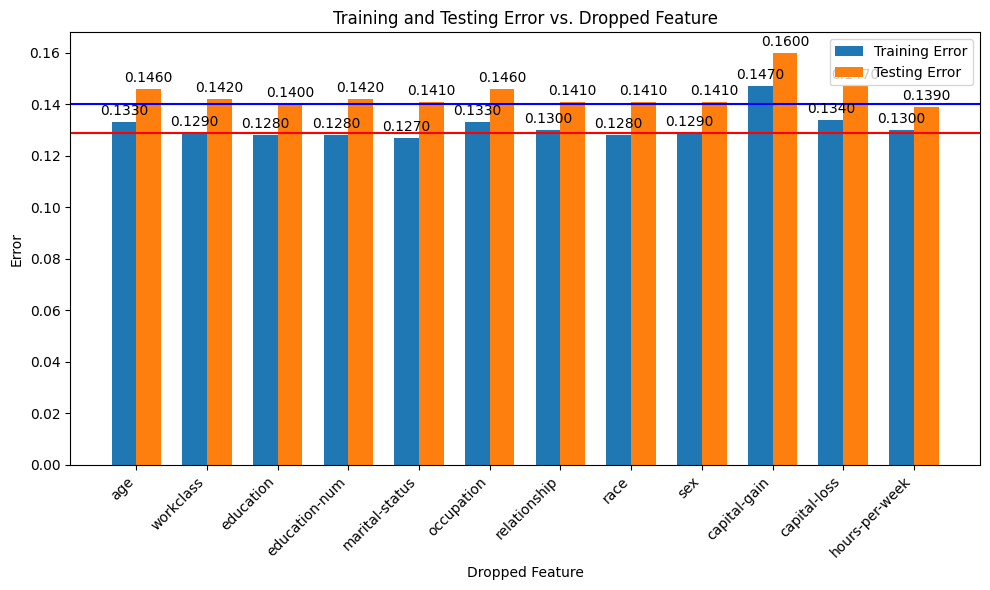

In [ ]:
# loop through each label to run on base dataset
training_errors = []
testing_errors = []
for label in X.columns:

  X_dropped = X.drop(label, axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_dropped, y, test_size=0.3, random_state=1234)

  training_error, testing_error, _ = xgboost(X_train, X_test, y_train, y_test)
  training_errors.append(training_error)
  testing_errors.append(testing_error)

#Plot training/testing error vs dropped feature
dropped_feature = X.columns

#Plot training/testing error xgb_error[0]vs dropped feature
x = np.arange(len(dropped_feature))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, training_errors, width, label='Training Error')
rects2 = ax.bar(x + width/2, testing_errors, width, label='Testing Error')

y_training, y_testing = xgb_error[0], xgb_error[1]
ax.axhline(y=y_training, color='r', linestyle='-')
ax.axhline(y=y_testing, color='b', linestyle='-')

ax.set_xlabel('Dropped Feature')
ax.set_ylabel('Error')
ax.set_title('Training and Testing Error vs. Dropped Feature')
ax.set_xticks(x)
ax.set_xticklabels(dropped_feature, rotation=45, ha='right')
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.4f')
ax.bar_label(rects2, padding=3, fmt='%.4f')

fig.tight_layout()
plt.show()

In [ ]:
labels = list(X.columns)
for feature in labels:
  if testing_errors[labels.index(feature)] == xgb_error[1]:
    X = X.drop(feature, axis=1)

print(X.columns)


Index(['age', 'workclass', 'education-num', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1234)

final_training_error, final_testing_error,_ = xgboost(X_train, X_test, y_train, y_test)
print(f"Final Training Error: {final_training_error}")
print(f"Final Testing Error: {final_testing_error}")

Final Training Error: 0.128
Final Testing Error: 0.14
